## Iterative pre-whitening examples
### TESS data

This notebook provides an example for running an iterative pre-whitening (IPW) analysis for a variable star observed by the TESS space satellite for a duration of 27 days.

For this notebook, you'll need to download: [test_tess.dat](https://iacerasmus.github.io/ERASMUS2022/data/test_tess.dat)

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from pythia.utils.resampling import run_mean_smooth
from pythia.timeseries.lombscargle import LS_periodogram
from pythia.timeseries.iterative_prewhitening import run_ipw



plt.rcParams.update({
    "text.usetex": True,
        "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
         r"\usepackage{amsmath}",
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
    ]),
})

plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

Let's open the example TESS data, calculate the window function, and see what the periodogram looks like!

In [2]:
times,fluxes = np.loadtxt("../data/test_tess.dat",unpack=True)
nu_w,amp_w = LS_periodogram(times,np.ones_like(times),min=0.0001,max=5.)
nu,amp = LS_periodogram(times,fluxes-np.mean(fluxes),max=50.)


<IPython.core.display.Javascript object>


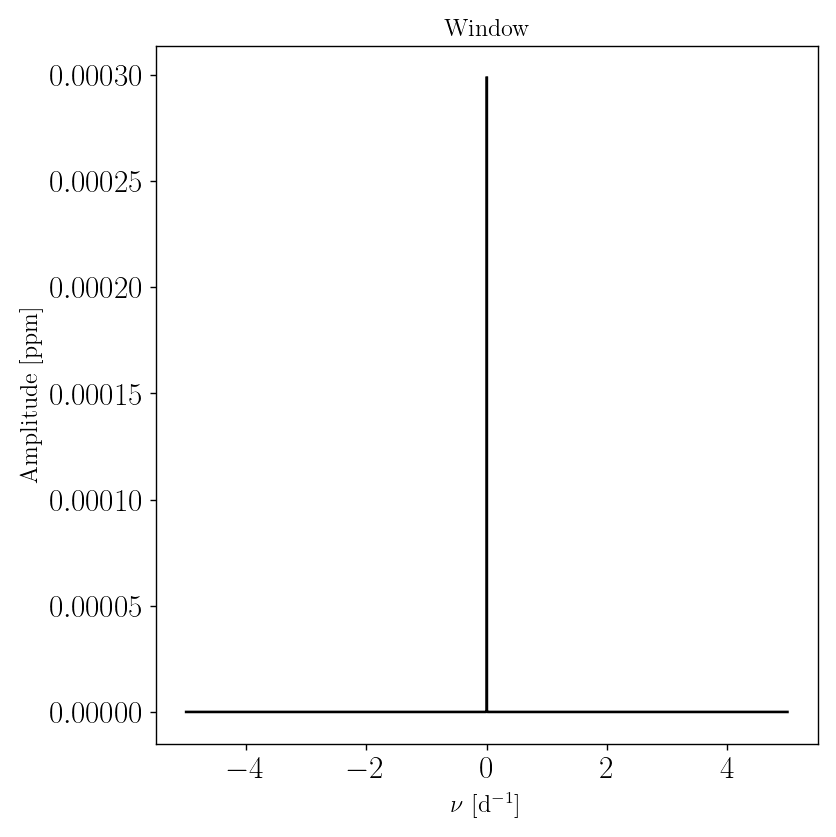

In [3]:
figw,axw = plt.subplots(1,1,figsize=(6.6957,6.6957),num=1)
axw.plot(nu_w,amp_w*1e6,'k-')
axw.plot(nu_w*-1,amp_w*1e6,'k-')
axw.set_xlabel(r'$\nu\,\,{\rm [d^{-1}]}$',fontsize=14)
axw.set_ylabel(r'${\rm Amplitude\,\,[ppm]}$',fontsize=14)
axw.set_title(r'${\rm Window}$',fontsize=14)
figw.tight_layout()

<IPython.core.display.Javascript object>


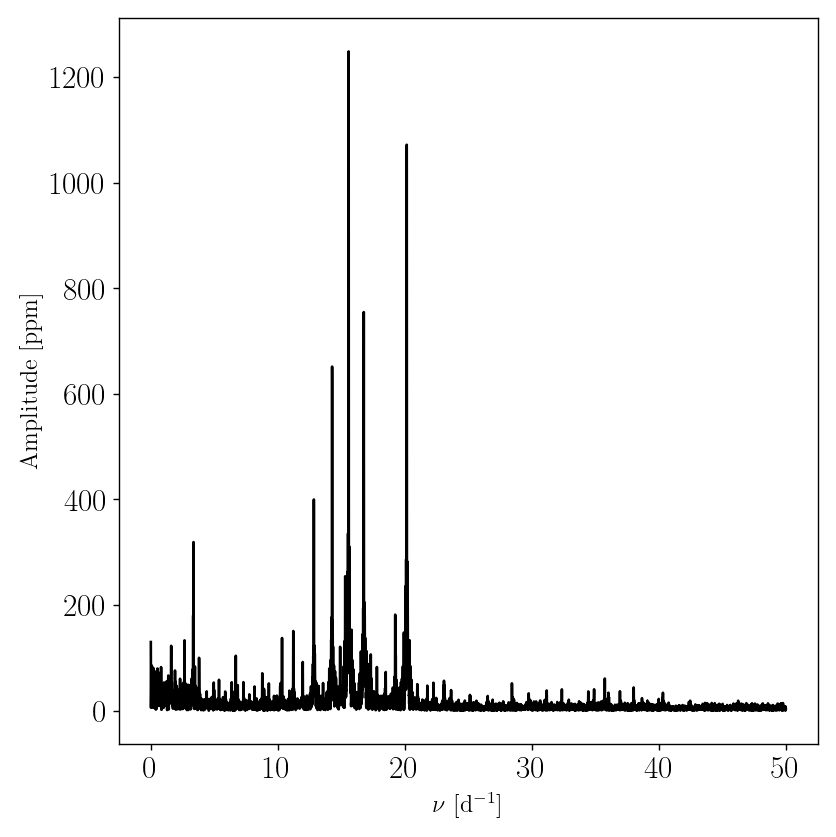

In [4]:
fig,ax = plt.subplots(1,1,figsize=(6.6957,6.6957),num=2)
ax.plot(nu,amp*1e6,'k-')
ax.set_xlabel(r'$\nu\,\,{\rm [d^{-1}]}$',fontsize=14)
ax.set_ylabel(r'${\rm Amplitude\,\,[ppm]}$',fontsize=14)
fig.tight_layout()

This example is clearly different from the ground-based observations of the RR Lyrae variable. 

There are clearly many, many more frequencies, the window function is much less of an issue, and the there's a large range in amplitude for the frequencies that we see here. 

We should decide up front how may frequencies we want to extract and how we want to apply the stopping criterion.

## Signal-to-noise ratio
Typically the significance of a given extracted frequency (or its singal-to-noise ration; SNR) is calculated as the ratio of the amplitude of the signal to some estimate of the noise. 

The nuance lies in how we estimate the noise level. Generally, there are two approaches.

### Approach 1: Frequency window
The approach first considers the average noise level in a window surrounding the peak being extracted. This approach is complicated by considering the size of the window to use, as there is no uniformly accepted value.

Let us consider two different window sizes and compare the relative noise levels.

In [5]:
def get_noise_level_window(nu, amp, window=1.):
    
    npoints = len( nu[ nu <= nu[0] + window ])
    mean_ = run_mean_smooth(amp, npoints)

    return mean_

<IPython.core.display.Javascript object>


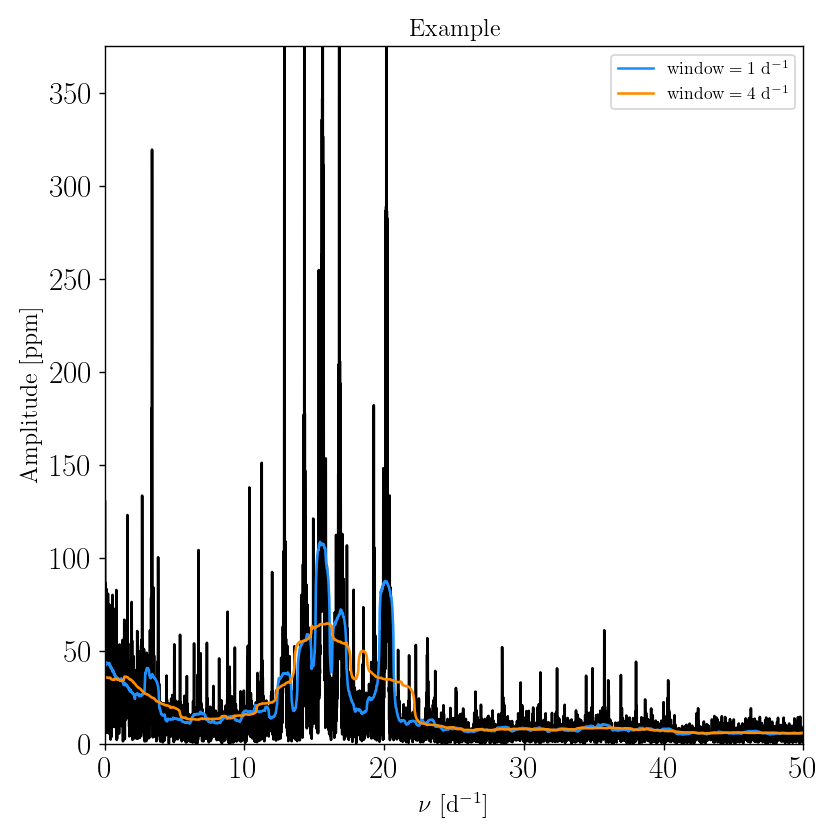

In [6]:
window_1 = 1. #c/d
window_2 = 4. #c/d

noise_1 = get_noise_level_window(nu, amp, window_1)
noise_2 = get_noise_level_window(nu, amp, window_2)

fig,ax = plt.subplots(1,1,figsize=(6.6957,6.6957),num=3)
ax.plot(nu,amp*1e6,'k-')
ax.plot(nu,noise_1*1e6,'-', color='dodgerblue', label=r'${\rm window=1~d^{-1}}$')
ax.plot(nu,noise_2*1e6,'-', color='darkorange', label=r'${\rm window=4~d^{-1}}$')

ax.set_xlabel(r'$\nu\,\,{\rm [d^{-1}]}$',fontsize=14)
ax.set_ylabel(r'${\rm Amplitude\,\,[ppm]}$',fontsize=14)
ax.set_title(r'${\rm Example}$',fontsize=14)
ax.legend(loc='upper right')
ax.set_xlim(0., 50)
ax.set_ylim(0., 375)
fig.tight_layout()

We can clearly see that the estimated noies levels change for frequency regions with a high denisty of modes.

### White-noise frequency range

The second approach considers the average noise level at some high frequency range that is presumed to be dominated by white-noise. 


In [7]:
def get_noise_level_range(nu, amp, noise_range):
    
    idx = np.where( ((nu>=noise_range[0]) & (nu<=noise_range[1])) )
    mean_ = np.ones_like(nu) * np.median(amp[idx])

    return mean_

<IPython.core.display.Javascript object>


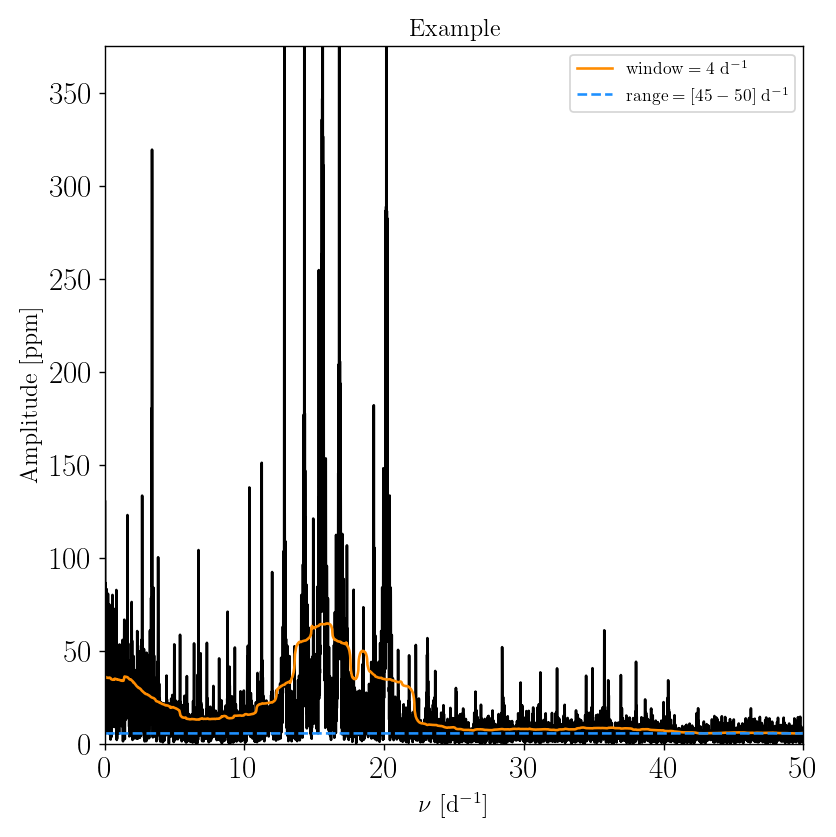

In [8]:
range_1 = [45.,50.]
noise_range_1 = get_noise_level_range(nu, amp, range_1)

fig,ax = plt.subplots(1,1,figsize=(6.6957,6.6957),num=4)
ax.plot(nu,amp*1e6,'k-')
ax.plot(nu,noise_2*1e6,'-', color='darkorange', label=r'${\rm window=4~d^{-1}}$')
ax.plot(nu,noise_range_1*1e6,'--', color='dodgerblue', label=r'${\rm range=[45-50]~d^{-1}}$')

ax.set_xlabel(r'$\nu\,\,{\rm [d^{-1}]}$',fontsize=14)
ax.set_ylabel(r'${\rm Amplitude\,\,[ppm]}$',fontsize=14)
ax.set_title(r'${\rm Example}$',fontsize=14)
ax.legend(loc='upper right')
ax.set_xlim(0., 50)
ax.set_ylim(0., 375)
fig.tight_layout()

Here, we can clearly see that the estimated noise level from the "white noise" frequency range results in a constant, and __much__ lower noise level than the moving window.

## When to stop

What SNR should you use to stop?
  - SNR $\ge$ 4 (Breger et al. 1993)
  - SNR $\ge$ 5.6 (Baran et al. 2015)
  - Bayesian information criterion (de Groote et al. 2009a; Sekaran et al. 2020)
  - $p$-value (Blomme et al. 2011; Papics et al. 2012)
  
For ground based -- SNR $\ge$ 4 is sufficient.
For spaced based data, the points are correlated! --> Need a higher SNR.
Several studies demonstrate that using BIC or $p$-value related stopping criterion can result in over-extraction.

For simplicity, if we're using ground-based data, we'll stick to SNR $\ge$ 4, and for space-based data we'll stick to SNR $\ge$ 5.6.

## Order of removal

This may seem pedantic, but we need to decide what order to extract frequencies in. 
Nominally, people select on the highest amplitude signal left in a periodogram. However, it is also common to select on the signal with the highest SNR. Depending on how you estimate the noise level, this can change. 

For instance, if we use the white-noise SNR range from high frequencies, the noise level is constant, and the SNR and amplitude removal approaches reduce to the same result.

However, if we use a running window:

<IPython.core.display.Javascript object>


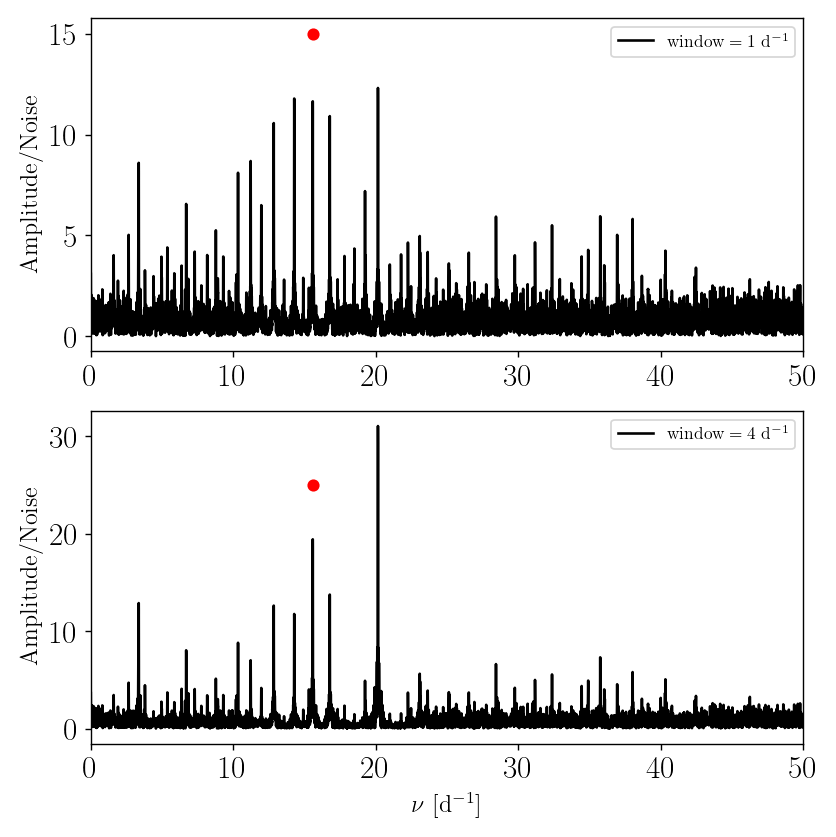

In [9]:
snr_w1 = amp/noise_1
snr_w2 = amp/noise_2

fig,axes = plt.subplots(2,1,figsize=(6.6957,6.6957),num=5)

axes[0].plot(nu,(amp/noise_1),'-', color='black', label=r'${\rm window=1~d^{-1}}$')
axes[0].plot(nu[np.argmax(amp)], 15, 'ro')
axes[1].plot(nu,(amp/noise_2),'-', color='black', label=r'${\rm window=4~d^{-1}}$')
axes[1].plot(nu[np.argmax(amp)], 25, 'ro')


axes[0].set_ylabel(r'${\rm Amplitude / Noise}$',fontsize=14)
axes[1].set_ylabel(r'${\rm Amplitude / Noise}$',fontsize=14)
axes[1].set_xlabel(r'$\nu\,\,{\rm [d^{-1}]}$',fontsize=14)
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[0].set_xlim(0., 50)
axes[1].set_xlim(0., 50)
# ax.set_ylim(0., 375)
fig.tight_layout()

In these plots, the red dot denotes the frequency that would be extracted first if we had decided to extract in order of highest amplitude signal. 

In contrast,we can see that the signal at ~20 ${\rm d^{-1}}$ has a higher SNR, and would be selected first. 
The order in which the remaining frequencies would be extracted according to SNR further depends on how large of a window we use, which can be seen by comparing the top and bottom panels of the above figure. 

The order might be more or less important for your specific science case, the only advice I can give is to try a few methods and see what the results are. And most importantly -- __WRITE DOWN WHAT YOU'VE DONE IN YOUR PAPER__.